In [2]:
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Lambda, Flatten, Reshape, MaxPooling2D
from keras.models import Model
from keras.optimizers import RMSprop
from keras.losses import mean_squared_error, binary_crossentropy, kullback_leibler_divergence
from keras.callbacks import EarlyStopping, TerminateOnNaN, ReduceLROnPlateau
from keras import backend as K
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, scipy
from sklearn.model_selection import train_test_split

from phenom_read_in_data import *

Using TensorFlow backend.


In [3]:
#Getthe data
df = single_csv_to_df('Documents/Work/PhD/dark_machines/training_files/chan1/background_chan1_7.79.csv')

In [3]:
df

,event_ID,process_ID,event_weight,MET,MET_Phi,obj1,E1,pt1,eta1,phi1,...,obj13,E13,pt13,eta13,phi13,obj14,E14,pt14,eta14,phi14
0,7051621,z_jets,1,390017,0.538031,j,407492,393095,-0.266637,-2.68505,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,33064349,njets,1,217448,0.663545,j,707690,390901,1.19577,-2.48665,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,179392659,njets,1,220238,-1.45891,j,484710,388499,0.669438,2.1595,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,185746896,njets,1,237999,1.30691,j,913056,245434,-1.98767,0.978061,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,84616096,njets,1,229855,-0.953545,j,302325,294936,0.181659,3.03634,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214180,134098620,njets,1,236904,0.294278,j,647782,316987,-1.33574,0.0408877,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214181,15237232,njets,1,263035,-2.15702,j,390920,325540,0.606702,0.269049,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214182,20494126,njets,1,344296,-1.45284,j,1.04316e+06,309613,-1.88456,1.17333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214183,85321109,njets,1,227666,0.495691,j,450608,309967,-0.89566,-2.33551,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
#If the number of max objects is prime, another column needs to be added to mitigate 

In [ ]:
df['obj14']= -999
df['E14'] = -999
df['pt14'] = -999
df['eta14'] = -999
df['phi14'] = -999

In [4]:
df = df.fillna(-999)
variables = [entry for entry in df.columns if entry[0] == 'E'] + [entry for entry in df.columns if entry[0:2] == 'pt'] + [entry for entry in df.columns if entry[0:2] == 'et'] + [entry for entry in df.columns if entry[0:2] == 'ph']

In [5]:
#Now we one_hot encode the data to make sure we have a class definition
df = df[['process_ID']+variables]
one_hot = pd.get_dummies(df['process_ID'])
processes = one_hot.columns
df.drop('process_ID', axis = 'columns', inplace = True)
df = pd.concat([df, one_hot], sort = False, axis = 1)

In [51]:
pd.set_option('display.max_columns', 70)
df

,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,E11,E12,E13,E14,pt1,pt2,pt3,pt4,pt5,pt6,pt7,pt8,pt9,pt10,pt11,pt12,pt13,pt14,eta1,eta2,eta3,eta4,eta5,eta6,eta7,...,phi5,phi6,phi7,phi8,phi9,phi10,phi11,phi12,phi13,phi14,2gam,4top,Wgam,Zgam,atop,atopbar,gam_jets,njets,singletop,singletopbar,ttbar,ttbarGam,ttbarHiggs,ttbarW,ttbarWW,ttbarZ,w_jets,wtop,wtopbar,ww,z_jets,ztop,ztopbar,zw,zz
0,407492,633731,269569,138520,101435,183193,-999,-999,-999,-999,-999,-999,-999,-999,393095,283693,145318,110826,87189.8,38577.6,-999,-999,-999,-999,-999,-999,-999,-999,-0.266637,1.4419,1.22541,0.688498,0.563578,-2.23818,-999,...,-2.49198,-0.295831,-999,-999,-999,-999,-999,-999,-999,-999,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,707690,165970,213806,190327,324303,-999,-999,-999,-999,-999,-999,-999,-999,-999,390901,162374,88382.7,63638.8,56631.5,-999,-999,-999,-999,-999,-999,-999,-999,-999,1.19577,-0.073124,1.52776,-1.75736,2.42978,-999,-999,...,3.03834,-999,-999,-999,-999,-999,-999,-999,-999,-999,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,484710,466224,173345,76508.9,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,388499,209644,159358,63430.3,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,0.669438,1.43709,0.3921,0.614221,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,913056,228497,153458,126963,50958.8,-999,-999,-999,-999,-999,-999,-999,-999,-999,245434,202999,146721,126389,41187,-999,-999,-999,-999,-999,-999,-999,-999,-999,-1.98767,0.478876,-0.259158,0.0382953,0.653297,-999,-999,...,2.54775,-999,-999,-999,-999,-999,-999,-999,-999,-999,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,302325,360228,203074,359058,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,294936,251837,200825,56262.1,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,0.181659,-0.8903,0.149532,2.54026,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214180,647782,1.03028e+06,442513,353545,34124.5,-999,-999,-999,-999,-999,-999,-999,-999,-999,316987,278691,190614,120815,24021.7,-999,-999,-999,-999,-999,-999,-999,-999,-999,-1.33574,1.98139,-1.48267,1.73419,0.867112,-999,-999,...,-2.37522,-999,-999,-999,-999,-999,-999,-999,-999,-999,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
214181,390920,1.83279e+06,197980,191427,54929.9,76348.3,-999,-999,-999,-999,-999,-999,-999,-999,325540,265269,103625,56799.1,52948.5,43636.1,-999,-999,-999,-999,-999,-999,-999,-999,0.606702,2.62055,1.25981,-1.88419,0.25536,1.14312,-999,...,0.852269,2.3847,-999,-999,-999,-999,-999,-999,-999,-999,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
214182,1.04316e+06,809841,403629,400995,285868,-999,-999,-999,-999,-999,-999,-999,-999,-999,309613,304875,196592,83865.8,40030.8,-999,-999,-999,-999,-999,-999,-999,-999,-999,-1.88456,1.63051,1.34505,-2.24571,-2.65281,-999,-999,...,-0.773111,-999,-999,-999,-999,-999,-999,-999,-999,-999,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
214183,450608,216603,122718,132238,87140.8,-999,-999,-999,-999,-999,-999,-999,-999,-999,309967,214715,106325,85920.4,25784.8,-999,-999,-999,-999,-999,-999,-999,-999,-999,-0.89566,0.0388365,-0.535995,0.990861,1.88563,-999,-999,...,-0.156794,-999,-999,-999,-999,-999,-999,-999,-999,-999,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
E = [entry for entry in df.columns if entry[0] == 'E']
pt = [entry for entry in df.columns if entry[0:2] == 'pt']
eta = [entry for entry in df.columns if entry[0:2] == 'et']
phi = [entry for entry in df.columns if entry[0:2] == 'ph']

In [7]:
np_E = np.array(df[E])
np_pt = np.array(df[pt])
np_eta = np.array(df[eta])
np_phi = np.array(df[phi])

In [28]:
np_E

array([['407492', '633731', '269569', ..., -999, -999, -999],
       ['707690', '165970', '213806', ..., -999, -999, -999],
       ['484710', '466224', '173345', ..., -999, -999, -999],
       ...,
       ['1.04316e+06', '809841', '403629', ..., -999, -999, -999],
       ['450608', '216603', '122718', ..., -999, -999, -999],
       ['715153', '511507', '555581', ..., -999, -999, -999]],
      dtype=object)

In [23]:
data = [np_E, np_pt, np_eta, np_phi]

In [10]:
df[variables].values

array([['407492', '633731', '269569', ..., -999, -999, -999],
       ['707690', '165970', '213806', ..., -999, -999, -999],
       ['484710', '466224', '173345', ..., -999, -999, -999],
       ...,
       ['1.04316e+06', '809841', '403629', ..., -999, -999, -999],
       ['450608', '216603', '122718', ..., -999, -999, -999],
       ['715153', '511507', '555581', ..., -999, -999, -999]],
      dtype=object)

In [12]:
df[processes].values

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [8]:
#We have created a df of our values and some kind of class label
#We should normalize
x = df[variables].values
x_scaled = StandardScaler().fit_transform(x)
df[variables] = x_scaled

x_train, x_test, y_train, y_test = train_test_split(df[variables].values,
                                                    df[processes].values, 
                                                    shuffle = True,
                                                    random_state = 42,
                                                    test_size = 0.1)

In [132]:
x_train.shape

(192766, 56)

In [76]:
x_train[0].shape

(56,)

In [9]:
#Reshape the data. This will have to be done explicitly until you think of a clever way of doing it
x_train = x_train.reshape((x_train.shape[0], 1, 14, 4))
x_test = x_test.reshape((x_test.shape[0], 1, 14, 4))

In [153]:
def sampling(args):
    z_mean, z_log_var=args
    epsilon=tf.random.uniform(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean+K.exp(z_log_var/2)*epsilon

In [10]:
#VAE Model
original_dim = x_train.shape[0]
input_shape = x_train.shape[1:]
latent_dim = 4
intermediate_dim = 50
kernel_max_norm = 1000.
act_fun = 'relu'
epsilon_std = 1.
filters = 32
kernel_size = (2, 2)
strides = (1, 1)
pool_size = (1, 1)

#Layers
x_input = Input(shape = input_shape, name = 'Input')
conv_1 = Conv2D(filters = filters, 
                activation = act_fun,
                kernel_size = kernel_size,
                strides = strides, 
                padding = 'same')(x_input)
pool_1 = MaxPooling2D(pool_size = (1, 1),
                      strides = 2,
                      #data_format = 'channels_first'
                     )(conv_1)
conv_2 = Conv2D(filters = filters, 
                activation = act_fun, 
                kernel_size = kernel_size, 
                strides = strides, 
                padding = 'same')(pool_1)

#Shape info needed to inform the dense layer in the decoder
flatten = Flatten()(conv_2)
#cnn = Model(x_input, flatten, name = 'cnn')
#cnn.summary()

shape = input_shape

#Encoding
dense_encoder_1 = Dense(intermediate_dim,
                        activation = act_fun,
                        name = 'dense_encoder_1')(flatten)
dense_encoder_2 = Dense(16,
                        activation = act_fun,
                        name = 'dense_encoder_2')(dense_encoder_1)
z_mean = Dense(latent_dim, name = 'z_mean')(dense_encoder_2)
z_var = Dense(latent_dim, name = 'z_var')(dense_encoder_2)

z = Lambda(sampling, output_shape = (latent_dim, ), name = 'sampling')([z_mean, z_var])

encoder = Model(x_input, [z_mean, z_var, z], name = 'encoder')
encoder.summary()


#Decoding
decoder_input = Input(shape = (latent_dim, ), name = 'decoder_input')
dense_decoder_1 = Dense(shape[0]*shape[1]*shape[2], 
                        activation = act_fun, name = 'dense_decoder_1')(decoder_input)
reshape = Reshape((shape[0], shape[1], shape[2]))(dense_decoder_1)

deconv_1 = Conv2DTranspose(filters = filters,
                           kernel_size = kernel_size, 
                           activation = act_fun, 
                           strides = strides, 
                           padding = 'same', 
                           name = 'deconv_1')(reshape)
deconv_2 = Conv2DTranspose(filters = 16,
                           kernel_size = kernel_size, 
                           activation = act_fun, 
                           strides = strides, 
                           padding = 'same', 
                           name = 'deconv_2')(deconv_1)

output = Conv2DTranspose(filters = 7, 
                         kernel_size = kernel_size, 
                         activation = 'sigmoid', 
                         padding = 'same', 
                         strides = strides, 
                         name = 'decoder_output')(deconv_2)

decoder = Model(decoder_input, output, name = 'decoder')
decoder.summary()


#Build the VAE model
outputs = decoder(encoder(x_input)[2])
vae = Model(x_input, outputs, name = 'vae')

#Define some losses
def kl_loss(y_true, y_pred):
    kl_loss = 1 + z_var - K.square(z_mean) - K.exp(z_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    #kl_loss = K.mean(kl_loss)
    return kl_loss

def recon_loss(y_true, y_pred):
    recon_loss = mean_squared_error(K.flatten(y_true), K.flatten(y_pred))
    recon_loss *= shape[0]*shape[1]*shape[2]
    #recon_loss = K.mean(recon_loss)
    return recon_loss

def my_vae_loss(y_true, y_pred):
    recon = recon_loss(y_true, y_pred) 
    kl = kl_loss(y_true, y_pred)
    vae_loss = recon + kl
    return vae_loss


vae.compile(optimizer = 'rmsprop', loss = my_vae_loss, metrics = [kl_loss, recon_loss])
vae.summary()


In [11]:
K.clear_session()

In [45]:
def make_model(optimizer = 'rmsprop', filters = 32, intermediate_dim = intermediate_dim, act_fun = act_fun, 
               kernel_size = kernel_size, strides = strides):
    
    def sampling(args):
        z_mean, z_log_var=args
        epsilon=tf.random.uniform(shape=(K.shape(z_mean)[0], latent_dim))
        return z_mean+K.exp(z_log_var/2)*epsilon
    
    #Define some losses
    def kl_loss(y_true, y_pred):
        kl_loss = 1 + z_var - K.square(z_mean) - K.exp(z_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        #kl_loss = K.mean(kl_loss)
        return kl_loss

    def recon_loss(y_true, y_pred):
        recon_loss = mean_squared_error(K.flatten(y_true), K.flatten(y_pred))
        recon_loss *= shape[0]*shape[1]*shape[2]
        #recon_loss = K.mean(recon_loss)
        return recon_loss

    def my_vae_loss(y_true, y_pred):
        recon = recon_loss(y_true, y_pred) 
        kl = kl_loss(y_true, y_pred)
        vae_loss = recon + kl
        return vae_loss

    
    #Layers
    x_input = Input(shape = input_shape, name = 'Input')
    conv_1 = Conv2D(filters = filters, 
                activation = act_fun,
                kernel_size = kernel_size,
                strides = strides, 
                padding = 'same', 
                name = 'conv_1')(x_input)
    pool_1 = MaxPooling2D(pool_size = pool_size,
                          strides = 2, 
                          name = 'max_pool')(conv_1)
    conv_2 = Conv2D(filters = filters, 
                activation = act_fun, 
                kernel_size = kernel_size, 
                strides = strides, 
                padding = 'same', 
                name = 'conv_2')(pool_1)
    #Shape info needed to inform the dense layer in the decoder
    flatten = Flatten()(conv_2)#(pool_1)
    cnn = Model(x_input, flatten, name = 'cnn')
    cnn.summary()

    shape = input_shape
    
    #Encoding
    dense_encoder_1 = Dense(intermediate_dim,
                            activation = act_fun,
                            name = 'dense_encoder_1')(flatten)
    dense_encoder_2 = Dense(16,
                            activation = act_fun,
                            name = 'dense_encoder_2')(dense_encoder_1)
    z_mean = Dense(latent_dim, name = 'z_mean')(dense_encoder_2)
    z_var = Dense(latent_dim, name = 'z_var')(dense_encoder_2)

    z = Lambda(sampling, output_shape = (latent_dim, ), name = 'sampling')([z_mean, z_var])

    encoder = Model(x_input, [z_mean, z_var, z], name = 'encoder')
    encoder.summary()
    
    #Decoding
    dense_shape = shape[0]*shape[1]*shape[2]
    decoder_input = Input(shape = (latent_dim, ), name = 'decoder_input')
    dense_decoder_1 = Dense(dense_shape, 
                            activation = act_fun, 
                            name = 'dense_decoder_1')(decoder_input)
    reshape = Reshape((shape[0], shape[1], shape[2]))(dense_decoder_1)

    deconv_1 = Conv2DTranspose(filters = filters,
                               kernel_size = kernel_size, 
                               activation = act_fun, 
                               strides = strides, 
                               padding = 'same', 
                               name = 'deconv_1')(reshape)
    deconv_2 = Conv2DTranspose(filters = 20,
                               kernel_size = kernel_size, 
                               activation = act_fun, 
                               strides = strides, 
                               padding = 'same', 
                               name = 'deconv_2')(deconv_1)

    output = Conv2DTranspose(filters = 4, 
                             kernel_size = kernel_size, 
                             #activation = 'sigmoid', 
                             padding = 'same', 
                             strides = strides, 
                             name = 'decoder_output')(deconv_2)

    decoder = Model(decoder_input, output, name = 'decoder')
    decoder.summary()
    
    #Build the VAE model
    outputs = decoder(encoder(x_input)[2])
    vae = Model(x_input, outputs, name = 'vae')
    
    vae.compile(optimizer = optimizer, loss = my_vae_loss, metrics = [kl_loss, recon_loss])
    vae.summary()
    
    return vae

In [46]:
#Fit the model
epochs = 100
batch_size = 1000

parameters = {
             'intermediate_dim' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
             'act_fun' : ['relu', 'softmax', 'sigmoid'], 
             'filters' : [16, 32, 64, 128, 256], 
             'kernel_size' : [(1,1), (2,2), (3,3)], 
             'strides' : [(1,1), (2,2), (3,3)]
             }

vae = make_model()
#vae = KerasClassifier(build_fn=make_model, epochs = epochs, batch_size = batch_size)
#acc_scorer = make_scorer(accuracy_score)
#grid_obj = GridSearchCV(estimator=vae, param_grid=parameters, scoring=acc_scorer)
#grid_obj = grid_obj.fit(x_train, x_train)

#Set the clf to the best combination of parameters
#vae = grid_obj.best_estimator_

history = vae.fit(x = x_train,
                  y = x_train,
                  validation_data = (x_train, x_train),
                  epochs = epochs,
                  batch_size = batch_size,
                  verbose = 2)

vae.save('cnn-vae_model.h5')

Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 1, 14, 4)          0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 1, 14, 32)         544       
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 1, 7, 32)          0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 1, 7, 32)          4128      
_________________________________________________________________
flatten_3 (Flatten)          (None, 224)               0         
Total params: 4,672
Trainable params: 4,672
Non-trainable params: 0
_________________________________________________________________
Model: "encoder"
__________________________________________________________________________________________________
Layer (type

Epoch 20/100
 - 6s - loss: 23.8511 - kl_loss: 2.1930 - recon_loss: 21.6495 - val_loss: 62533.9339 - val_kl_loss: 18500.1016 - val_recon_loss: 43980.5195
Epoch 21/100
 - 6s - loss: 25801.8195 - kl_loss: 5217.8691 - recon_loss: 20558.9922 - val_loss: 23.5300 - val_kl_loss: 2.2362 - val_recon_loss: 21.2869
Epoch 22/100
 - 6s - loss: 23.4692 - kl_loss: 2.2255 - recon_loss: 21.2370 - val_loss: 22.7935 - val_kl_loss: 2.1352 - val_recon_loss: 20.6524
Epoch 23/100
 - 6s - loss: 22.8862 - kl_loss: 2.1670 - recon_loss: 20.7130 - val_loss: 21.8457 - val_kl_loss: 2.3726 - val_recon_loss: 19.4684
Epoch 24/100
 - 6s - loss: 775988756178.6337 - kl_loss: 253275930624.0000 - recon_loss: 522079830016.0000 - val_loss: 27.4763 - val_kl_loss: 6.3210 - val_recon_loss: 21.1488
Epoch 25/100
 - 6s - loss: 25.5952 - kl_loss: 4.0525 - recon_loss: 21.5359 - val_loss: 23.0662 - val_kl_loss: 2.2406 - val_recon_loss: 20.8190
Epoch 26/100
 - 6s - loss: 22.8919 - kl_loss: 2.2420 - recon_loss: 20.6440 - val_loss: 22.32

Epoch 77/100
 - 6s - loss: 18.2240 - kl_loss: 2.1721 - recon_loss: 16.0497 - val_loss: 18.1004 - val_kl_loss: 2.1059 - val_recon_loss: 15.9921
Epoch 78/100
 - 6s - loss: 17.9520 - kl_loss: 2.1733 - recon_loss: 15.7766 - val_loss: 18.3427 - val_kl_loss: 2.2040 - val_recon_loss: 16.1359
Epoch 79/100
 - 6s - loss: 18.5007 - kl_loss: 2.1929 - recon_loss: 16.3099 - val_loss: 18.7062 - val_kl_loss: 2.1100 - val_recon_loss: 16.5936
Epoch 80/100
 - 6s - loss: 17.6440 - kl_loss: 2.2092 - recon_loss: 15.4319 - val_loss: 17.3650 - val_kl_loss: 2.1851 - val_recon_loss: 15.1781
Epoch 81/100
 - 6s - loss: 17.6487 - kl_loss: 2.1874 - recon_loss: 15.4613 - val_loss: 21.0429 - val_kl_loss: 3.7237 - val_recon_loss: 17.3150
Epoch 82/100
 - 6s - loss: 47.0767 - kl_loss: 4.2078 - recon_loss: 42.8336 - val_loss: 17.6810 - val_kl_loss: 2.1565 - val_recon_loss: 15.5221
Epoch 83/100
 - 6s - loss: 17.7915 - kl_loss: 2.1357 - recon_loss: 15.6551 - val_loss: 19.0745 - val_kl_loss: 2.1907 - val_recon_loss: 16.8797

In [47]:
y_pred = vae.predict(x_train.reshape(x_train.shape[0], 1, 14, 4))
#ravel returns flattened array

In [134]:
x_train.shape

(192766, 4, 1, 14)

In [48]:
x_train_reshape = x_train.reshape(x_train.shape[0], 56)

In [136]:
x_train_reshape

array([[-1.02999598,  1.69367452, -0.54473504, ..., -0.01449628,
        -0.00305578, -0.00216076],
       [ 0.65387735, -0.77987506,  1.94867868, ..., -0.01449628,
        -0.00305578, -0.00216076],
       [-0.58875039, -0.69080796, -0.35593085, ..., -0.01449628,
        -0.00305578, -0.00216076],
       ...,
       [-0.71320281, -0.67773757, -0.56324358, ..., -0.01449628,
        -0.00305578, -0.00216076],
       [-0.38904511,  0.05227302,  1.49509397, ..., -0.01449628,
        -0.00305578, -0.00216076],
       [-0.77199463, -0.92328747, -0.91171711, ..., -0.01449628,
        -0.00305578, -0.00216076]])

In [49]:
x_train_df = pd.DataFrame(x_train_reshape, columns = variables)

In [50]:
x_train_E = np.array(x_train_df[E])
x_train_pt = np.array(x_train_df[pt])
x_train_phi = np.array(x_train_df[phi])
x_train_eta = np.array(x_train_df[eta])

In [66]:
y_pred.shape

(192766, 1, 14, 4)

In [51]:
y_pred_reshape = y_pred.reshape(y_pred.shape[0], 56)

In [52]:
y_pred_df = pd.DataFrame(y_pred_reshape, columns = variables)

In [53]:
y_pred_E = np.array(y_pred_df[E])
y_pred_pt = np.array(y_pred_df[pt])
y_pred_phi = np.array(y_pred_df[phi])
y_pred_eta = np.array(y_pred_df[eta])

In [54]:
x_train_flat = x_train_reshape.flatten()

In [55]:
y_pred_flat = y_pred_reshape.flatten()

In [145]:
x_train_E.flatten()[0:10]

array([-1.02999598,  1.69367452, -0.54473504, -0.79423949, -0.84807384,
       -0.50833324, -0.29860819, -0.16303183, -0.08806662, -0.04571491])

In [146]:
y_pred_E.flatten()[0:10]

array([-0.43512207,  0.28458256,  0.44435745,  0.05629063, -0.7688857 ,
       -0.55472195, -0.3812923 , -0.22666687, -0.02839513, -0.00322596],
      dtype=float32)

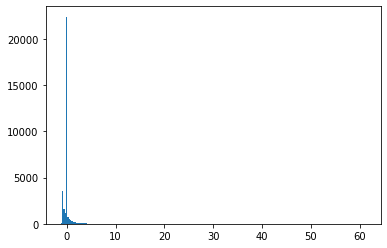

In [56]:
n, bins, patches = plt.hist(x_train_E.flatten()[:100000], 1000)

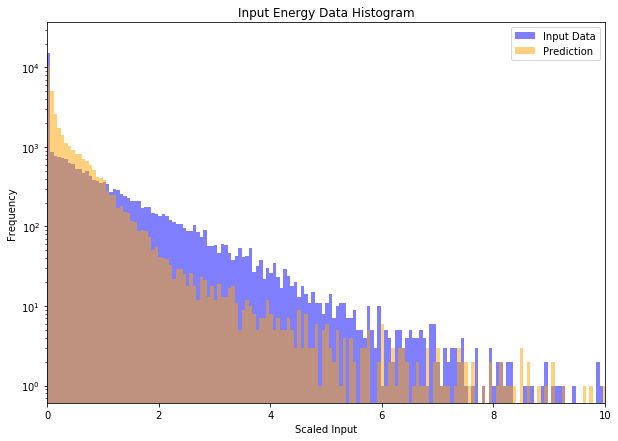

In [57]:
plt.figure(figsize=(10,7))
plt.xlim(0, 10)
plt.xlabel('Scaled Input')
plt.ylabel('Frequency')
plt.title('Input Energy Data Histogram')
plt.hist(x_train_E.flatten()[:100000], bins = bins, color='blue', log=True, label='Input Data', alpha=0.5)
plt.hist(y_pred_E.flatten()[:100000], bins = bins, color='orange', log=True, label='Prediction', alpha=0.5)
plt.legend()
plt.show()

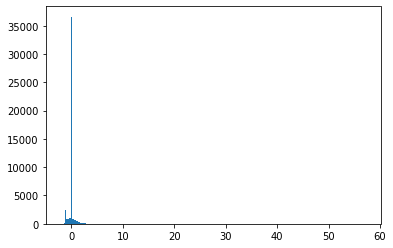

In [58]:
n, bins, patches = plt.hist(x_train_pt.flatten()[:100000], 1000)

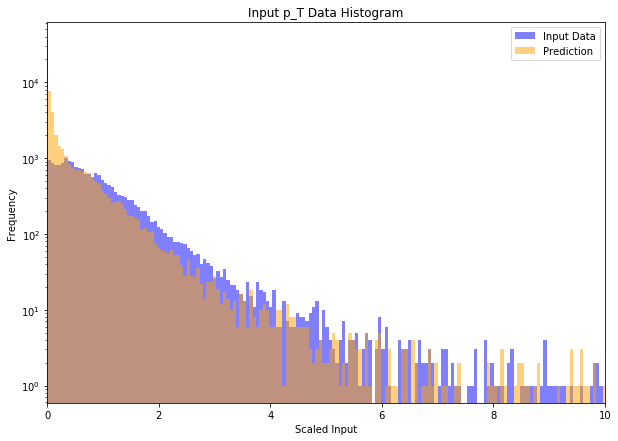

In [59]:
plt.figure(figsize=(10,7))
plt.xlim(0, 10)
plt.xlabel('Scaled Input')
plt.ylabel('Frequency')
plt.title('Input p_T Data Histogram')
plt.hist(x_train_pt.flatten()[:100000], bins = bins, color='blue', log=True, label='Input Data', alpha=0.5)
plt.hist(y_pred_pt.flatten()[:100000], bins = bins, color='orange', log=True, label='Prediction', alpha=0.5)
plt.legend()
plt.show()

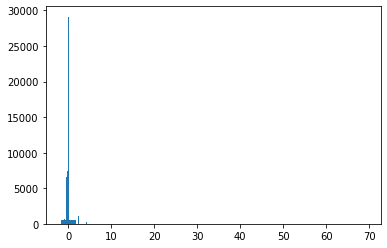

In [60]:
n, bins, patches = plt.hist(x_train_phi.flatten()[:100000], 1000)

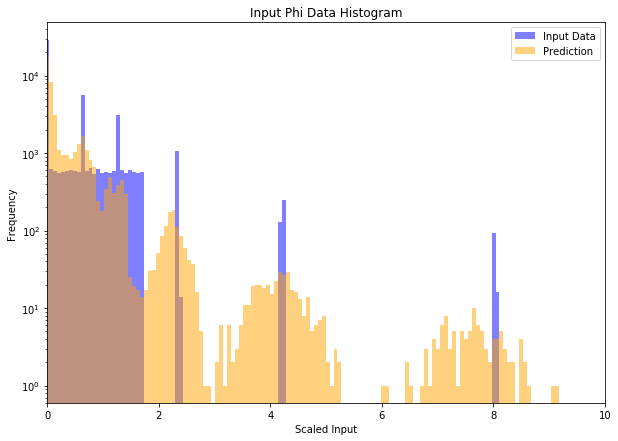

In [61]:
plt.figure(figsize=(10,7))
plt.xlim(0, 10)
plt.xlabel('Scaled Input')
plt.ylabel('Frequency')
plt.title('Input Phi Data Histogram')
plt.hist(x_train_phi.flatten()[:100000], bins = bins, color='blue', log=True, label='Input Data', alpha=0.5)
plt.hist(y_pred_phi.flatten()[:100000], bins = bins, color='orange', log=True, label='Prediction', alpha=0.5)
plt.legend()
plt.show()

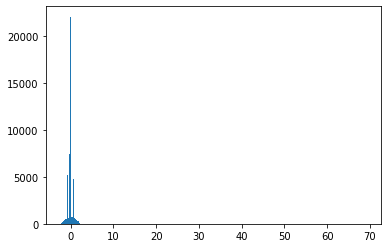

In [62]:
n, bins, patches = plt.hist(x_train_eta.flatten()[:100000], 1000)

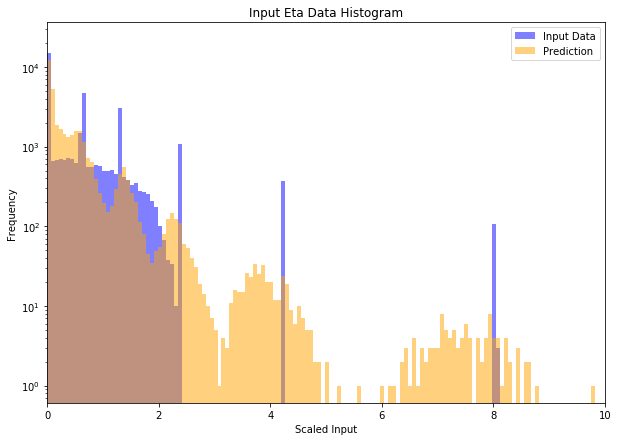

In [63]:
plt.figure(figsize=(10,7))
plt.xlim(0, 10)
plt.xlabel('Scaled Input')
plt.ylabel('Frequency')
plt.title('Input Eta Data Histogram')
plt.hist(x_train_eta.flatten()[:100000], bins = bins, color='blue', log=True, label='Input Data', alpha=0.5)
plt.hist(y_pred_eta.flatten()[:100000], bins = bins, color='orange', log=True, label='Prediction', alpha=0.5)
plt.legend()
plt.show()

In [39]:
x_train

array([[-1.02999598],
       [ 1.69367452],
       [-0.54473504],
       ...,
       [-0.01449628],
       [-0.00305578],
       [-0.00216076]])

In [64]:
good_history = [entry for entry in history.history['loss'] if entry<100]

In [65]:
good_val_hist = [entry for entry in history.history['val_loss'] if entry<100]

In [66]:
good_kl = [entry for entry in history.history['kl_loss'] if entry<100]

In [67]:
good_recon = [entry for entry in history.history['recon_loss'] if entry<100]

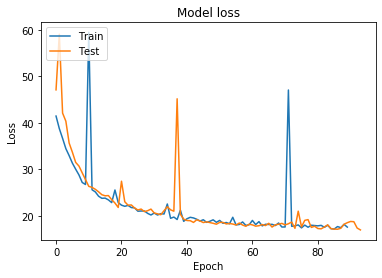

In [68]:
plt.plot(good_history)
plt.plot(good_val_hist)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [69]:
vae.metrics_names

['loss', 'kl_loss', 'recon_loss']

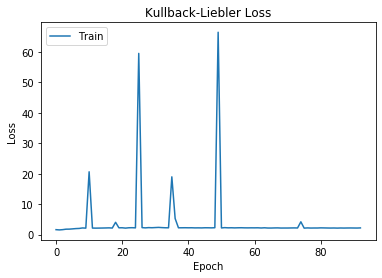

In [70]:
plt.plot(good_kl)
plt.title('Kullback-Liebler Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

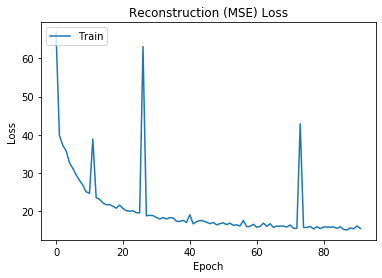

In [71]:
plt.plot(good_recon)
plt.title('Reconstruction (MSE) Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

In [80]:
history.history['loss']

[51.4782097015785,
 48.172797979209804,
 47.472684605483344,
 46.544676674977424,
 46.21558383302259,
 45.94880564989486,
 45.4688853127822,
 45.21190124580998,
 45.02788824571429,
 44.871058528638905,
 44.72132384249355,
 44.571036615562946,
 44.40950465121145,
 44.23567555918641,
 44.07911782584044,
 43.94541110768717,
 43.84298291244247,
 43.773290043115345,
 43.70705858649875,
 43.614629347126815,
 43.49966620316435,
 43.47596041577989,
 43.44527201773405,
 43.36921037204149,
 43.34140443386925,
 43.336737617957425,
 43.259618820496414,
 43.25925519166009,
 43.2295284494955,
 43.188366497731145,
 43.150138359921385,
 43.1321413644191,
 43.10800381695462,
 43.1137526097552,
 43.08895387624278,
 43.03944456870476,
 43.03655090793894,
 42.96947487330644,
 42.95866866441915,
 42.95463840572662,
 42.95922063076266,
 42.91591993570779,
 42.921844917583144,
 42.849978642891266,
 42.84469850434077,
 42.882464214387014,
 42.82739227214096,
 42.80939031089295,
 42.78575267279369,
 42.7557172

In [81]:
history.history['recon_loss']

[51.007343,
 47.93475,
 47.238335,
 46.216614,
 45.886784,
 45.593742,
 45.106915,
 44.786488,
 44.56558,
 44.384182,
 44.22243,
 44.047756,
 43.841827,
 43.642376,
 43.468704,
 43.301937,
 43.20637,
 43.195816,
 43.077484,
 42.958202,
 42.864742,
 42.838585,
 42.81204,
 42.711243,
 42.658382,
 42.68674,
 42.573975,
 42.5837,
 42.589615,
 42.97665,
 42.453876,
 42.4308,
 42.38161,
 42.403934,
 42.38919,
 42.333122,
 42.323395,
 42.286358,
 42.25498,
 42.224968,
 42.25153,
 42.19395,
 42.156223,
 42.184277,
 42.085724,
 42.08964,
 42.077732,
 42.015312,
 42.00207,
 41.96286,
 41.99014,
 41.929886,
 41.9601,
 41.906555,
 41.90587,
 41.866764,
 41.87174,
 41.840782,
 42.31589,
 41.89759,
 41.85532,
 41.757656,
 41.773415,
 41.743565,
 41.747364,
 41.73858,
 41.813583,
 41.750595,
 41.682747,
 41.703884,
 41.728073,
 41.67843,
 41.6578,
 41.647354,
 41.713284,
 41.610615,
 41.57402,
 41.652294,
 41.57863,
 41.534378,
 41.51742,
 41.551033,
 41.61009,
 41.525574,
 41.478287,
 41.543434,
 41

In [72]:
recon_num = len(good_recon)
loss_num = len(good_history)

In [73]:
print(recon_num, loss_num)

92 90


In [74]:
loss_diffs = [good_history[i]-good_recon[i] for i in range(loss_num)]

In [75]:
loss_diffs

[-25.373638879896262,
 -1.0457110224242783,
 -0.5265305764105008,
 -1.2932365193822193,
 0.30765777332133837,
 0.18988646302078038,
 0.6109347653888904,
 0.765449933009446,
 0.42673614519526026,
 1.772429420049523,
 34.84976719620107,
 -13.190542780788878,
 1.7098686434795844,
 1.2106864610156691,
 1.7084310181801392,
 2.216151745448517,
 1.8196870846122657,
 1.6492510458057694,
 4.882236823205684,
 1.3560214881085209,
 1.6919238871785396,
 2.0189598054168414,
 2.340073161752848,
 1.7991220155378755,
 2.2147590931315086,
 1.518026259018118,
 -42.00565243080994,
 2.3461432087059393,
 1.7194126641158007,
 1.4478500353308341,
 2.3474272613614033,
 2.323990889765028,
 2.2380049847503223,
 2.5250816894366928,
 4.3346102819134735,
 1.3230357059829316,
 2.4816257832063506,
 1.9877808728987922,
 3.723493550986703,
 1.8816396731502536,
 0.41863510234977497,
 3.1243140101105027,
 2.3942721360856503,
 1.8121983876121526,
 1.540860890468963,
 2.1593811671420653,
 1.9721289915979305,
 1.89255764875

In [76]:
len(loss_diffs)

90

In [87]:
epochs = [i+1 for i in range(100)]

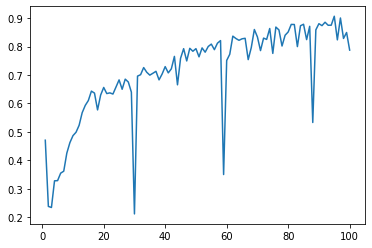

In [88]:
plt.plot(epochs,loss_diffs)

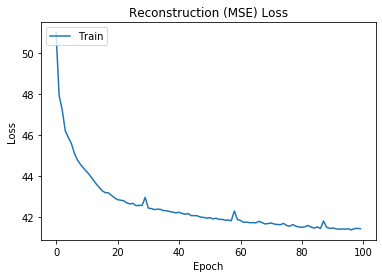

In [89]:
plt.plot(history.history['recon_loss'])
plt.title('Reconstruction (MSE) Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

In [90]:
anom_df = csv_to_df('gluino/')

In [38]:
anom_df

,event_ID,process_ID,event_weight,MET,MET_Phi,obj1,E1,pt1,eta1,phi1,...,obj18,E18,pt18,eta18,phi18,obj19,E19,pt19,eta19,phi19
0,21,gluino_01,1,332161,2.26593,j,760637,734103,0.126973,-0.501123,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21,gluino_01,1,341970,-1.54051,j,268137,239144,0.484389,0.80585,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21,gluino_01,1,127593,-0.838665,j,282508,169404,-1.08989,3.13979,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,21,gluino_01,1,254820,-1.21007,j,492500,202743,-1.53279,-1.11323,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,21,gluino_01,1,88214.6,0.365631,j,546629,482738,0.49185,3.0645,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2723,30,gluino_02,1,566719,2.51652,j,725980,610037,-0.560869,-0.689265,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2724,30,gluino_02,1,295629,1.0568,j,798406,485601,1.07319,-1.12604,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2725,30,gluino_02,1,530588,-0.2132,j,558691,473738,-0.502534,3.06139,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2726,30,gluino_02,1,128680,0.759799,j,280771,271452,0.0784046,-1.42927,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
anom_df.columns

Index(['event_ID', 'process_ID', 'event_weight', 'MET', 'MET_Phi', 'obj1',
       'E1', 'pt1', 'eta1', 'phi1', 'obj2', 'E2', 'pt2', 'eta2', 'phi2',
       'obj3', 'E3', 'pt3', 'eta3', 'phi3', 'obj4', 'E4', 'pt4', 'eta4',
       'phi4', 'obj5', 'E5', 'pt5', 'eta5', 'phi5', 'obj6', 'E6', 'pt6',
       'eta6', 'phi6', 'obj7', 'E7', 'pt7', 'eta7', 'phi7', 'obj8', 'E8',
       'pt8', 'eta8', 'phi8', 'obj9', 'E9', 'pt9', 'eta9', 'phi9', 'obj10',
       'E10', 'pt10', 'eta10', 'phi10', 'obj11', 'E11', 'pt11', 'eta11',
       'phi11', 'obj12', 'E12', 'pt12', 'eta12', 'phi12', 'obj13', 'E13',
       'pt13', 'eta13', 'phi13', 'obj14', 'E14', 'pt14', 'eta14', 'phi14',
       'obj15', 'E15', 'pt15', 'eta15', 'phi15', 'obj16', 'E16', 'pt16',
       'eta16', 'phi16', 'obj17', 'E17', 'pt17', 'eta17', 'phi17', 'obj18',
       'E18', 'pt18', 'eta18', 'phi18', 'obj19', 'E19', 'pt19', 'eta19',
       'phi19'],
      dtype='object')

In [40]:
anom_df = anom_df[anom_df.columns[:75]]

In [41]:
anom_df

,event_ID,process_ID,event_weight,MET,MET_Phi,obj1,E1,pt1,eta1,phi1,...,obj13,E13,pt13,eta13,phi13,obj14,E14,pt14,eta14,phi14
0,21,gluino_01,1,332161,2.26593,j,760637,734103,0.126973,-0.501123,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21,gluino_01,1,341970,-1.54051,j,268137,239144,0.484389,0.80585,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21,gluino_01,1,127593,-0.838665,j,282508,169404,-1.08989,3.13979,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,21,gluino_01,1,254820,-1.21007,j,492500,202743,-1.53279,-1.11323,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,21,gluino_01,1,88214.6,0.365631,j,546629,482738,0.49185,3.0645,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2723,30,gluino_02,1,566719,2.51652,j,725980,610037,-0.560869,-0.689265,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2724,30,gluino_02,1,295629,1.0568,j,798406,485601,1.07319,-1.12604,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2725,30,gluino_02,1,530588,-0.2132,j,558691,473738,-0.502534,3.06139,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2726,30,gluino_02,1,128680,0.759799,j,280771,271452,0.0784046,-1.42927,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
anom_df = anom_df.fillna(0)
anom_vars = [entry for entry in anom_df.columns if entry[0] == 'E'] + [entry for entry in anom_df.columns if entry[0:2] == 'pt'] + [entry for entry in anom_df.columns if entry[0:2] == 'et'] + [entry for entry in anom_df.columns if entry[0:2] == 'ph']
#Now we one_hot encode the data to make sure we have a class definition
anom_df = anom_df[['process_ID']+anom_vars]
anom_one_hot = pd.get_dummies(anom_df['process_ID'])
anom_processes = anom_one_hot.columns
anom_df.drop('process_ID', axis = 'columns', inplace = True)
anom_df = pd.concat([anom_df, anom_one_hot], sort = False, axis = 1)

In [43]:
#We have created a df of our values and some kind of class label
#We should normalize
anom_x = anom_df[anom_vars].values
anom_scaled = StandardScaler().fit_transform(anom_x)
anom_df[anom_vars] = anom_scaled

anom_x_train, anom_x_test, anom_y_train, anom_y_test = train_test_split(anom_df[anom_vars].values,
						    anom_df[anom_processes].values, 
                                                    shuffle = True,
                                                    random_state = 42,
                                                    test_size = 0.1)

In [44]:
#Reshape the data. This will have to be done explicitly until you think of a clever way of doing it
anom_x_train = anom_x_train.reshape((anom_x_train.shape[0], 4, 2, 7))
anom_x_test = anom_x_test.reshape((anom_x_test.shape[0], 4, 2, 7))

In [45]:
vae.evaluate(x_train[:500], anom_x_train[:500])

500/500 [==============================] - 0s 61us/step


[71.06890545654296, 1.057161808013916, 69.65178680419922]

In [133]:
temp_df = pd.DataFrame(x_train, columns=variables)

In [134]:
temp_df_E = temp_df[E]

In [ ]:
plt.hist(temp_df_E, bins = 30)